In [133]:
import numpy as np
import pandas as pd
import ast
import matplotlib.pyplot as plt


from main import getFutureData
from genCo import getGenCos

In [161]:
# Load the Excel file into a pandas DataFrame
file_path = "./paymentsPFP_with_info.xlsx"
df = pd.read_excel(file_path)

# Apply a map to convert string lists like '[2.4]' to float values
df_numeric = df.iloc[:, :-1].applymap(lambda x: ast.literal_eval(x)[0] if isinstance(x, str) else x)
df_numeric

# df.head()

,CSC#_1,CSC#_2,CSC#_3,CSC#_4,CSC#_5,CSC#_6,CSC#_7,CSC#_8,CSC#_9,CSC#_10,...,CSC#_17,CSC#_18,CSC#_19,CSC#_20,CSC#_21,CSC#_22,CSC#_23,CSC#_24,CSC#_25,id
0,1.867928,105.973484,105.973484,105.973484,99.677632,9.339641,24.570579,5.419794,4.219650,30.868635,...,9.394122,12.203922,0.000000,216.726374,4.483028,17.214827,363.996950,360.821472,10.928937,253
1,11.456627,4.820282,13.231158,13.231158,13.231158,72.612597,17.629694,11.577264,11.577264,46.119148,...,31.754780,31.754780,3.666619,5.912740,4.383405,5.603785,7.004731,8.838414,8.838414,321
2,8.838414,11.577264,6.010059,86.421718,10.548066,1.338682,10.967727,0.000000,22.166237,25.343583,...,10.410587,4.939114,53.011959,9.619052,24.656653,11.207320,12.204016,3.237742,3.113214,322
3,38.161774,7.396996,33.323466,11.577264,0.000000,0.000000,566.542636,863.916813,132.062527,11.596099,...,168.521373,261.640709,286.577551,11.908043,0.000000,177.108270,176.636898,10.277497,15.877390,323
4,6.388315,56.598226,4.901942,8.272307,28.038848,26.621091,7.160174,815.195547,31.054307,27.846887,...,13.486442,31.130269,5.043406,0.000000,14.121538,9.339641,24.905710,24.905710,61.953202,326
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1105,6.226427,10.330888,2.832402,4.152404,2.521080,36.984979,9.750585,0.806945,1.053512,5.715860,...,8.962320,1.480644,7.396996,1.008681,2.118231,0.331246,1.047908,1.023625,0.000000,-6
1106,0.000000,0.734718,0.729737,1.950117,0.672454,8.032091,10.634115,2.104532,1.681135,0.451416,...,13.919801,0.739700,0.672454,2.179250,0.933964,5.292463,3.424535,0.622643,12.404911,-7
1107,1.344908,2.555326,1.344908,0.672454,7.403845,1.344908,0.806945,0.000000,12.820214,11.100475,...,15.330710,0.000000,0.000000,10.579323,7.535223,4.975538,11.013928,3.617554,24.552671,-8
1108,0.000000,0.840568,0.000000,7.291147,6.029050,0.048566,0.463869,0.546058,0.457020,1.613890,...,2.017362,2.192325,2.017362,2.017362,2.017362,2.017362,2.017362,2.017362,2.689817,-9


In [135]:
# Get Future Load and Data
dfHourlyLoad, dfHourlySolar, dfHourlyWind, dfISO, info = getFutureData(ISO='ISNE', verbose=False, path='data/forecast/' , 
                                                                        load_rate='low', vre_mix='low')
genCos =  getGenCos(dfISO, esCharge=0.1)

In [157]:
p2 = 9337
# def demand_curve(x, genCos, TotMaxCSO):
#     # print(x, TotMaxCSO)
#     ICAP = np.sum(list(genco.MaxCap for genco in genCos))
#     OGCSO = TotMaxCSO
#     a = 5
#     alpha = a / (ICAP - OGCSO)
#     return - alpha * (x - ICAP)

def demandCurve(x):
    assert x >= 0.0
    cnt1x = 20.0
    cnt2x = 32.0
    maxPrice = 14.5

    if x <= cnt1x:
        return maxPrice * 1000 #$/MW-month 
    else:
        return np.maximum(maxPrice - maxPrice/(cnt2x-cnt1x) * (x - cnt1x), 0.0) * 1000
 

In [158]:
for gen in genCos: gen.updateCSO(dfISO, 'FCA Qual', vreOut=False);
totalCSO = np.sum([gen.CapObl for gen in genCos])
TotMaxCSO = np.sum([gen.CapObl for gen in genCos])

sumOfLoads = df.iloc[:, :-1].sum().sum()
print(sumOfLoads)

previousCSO = -1.0
while True:
    # priceP1 = demand_curve(totalCSO, genCos, TotMaxCSO)
    priceP1 = demandCurve(totalCSO / 1000)
    print('--Price P1: ', priceP1, 'Total CSO: ', totalCSO)
    print('Critical point: ', (9.337 / (priceP1 * 12)) * sumOfLoads - totalCSO)

    # Update CSO based on the current P1 price
    np.random.shuffle(genCos)
    for gen in genCos: 
        gen.updateCSOinFCA(dfISO, currentCSO=totalCSO, currentP1=priceP1, P2=9.337, sumOfLoads=sumOfLoads, vreOut=False);
        totalCSO = np.sum([gen.CapObl for gen in genCos])
        # priceP1 = demand_curve(totalCSO / 1000, genCos, TotMaxCSO)
        priceP1 = demandCurve(totalCSO / 1000)


    if np.abs(previousCSO - totalCSO) < 1:
        break
    else:
        previousCSO = totalCSO

/tmp/ipykernel_29383/2227833713.py:5: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  sumOfLoads = df.iloc[:, :-1].sum().sum()


27247508
--Price P1:  8730.54985795962 Total CSO:  24774.71735892997
Critical point:  -22346.36723269618
--Price P1:  8730.54985795962 Total CSO:  24774.71735892997
Critical point:  -22346.36723269618


In [159]:
p2, priceP1

(9337, 8730.54985795962)

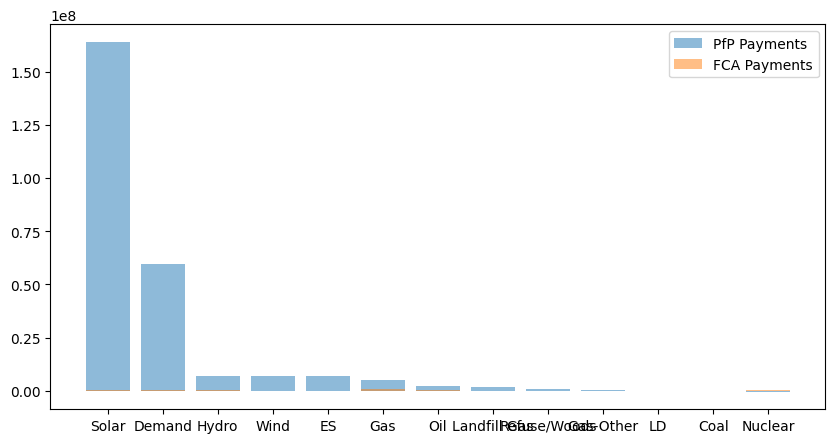

In [160]:
payment = []
paymentsByFuel, csoByFuel = {}, {}

br = df_numeric.iloc[:, :-1].sum(axis=0) / totalCSO
for i in range(len(genCos)):
    genco = genCos[i]
    paid =  p2 * (df_numeric[df['id'] == genCos[i].ID].sum(axis=1) - br.sum() * genCos[i].CapObl)
    payment.append(paid.values[0])
    if genco.fuelType in paymentsByFuel:
        paymentsByFuel[genco.fuelType] += paid.item()
        csoByFuel[genco.fuelType] += genco.CapObl
    else:
        paymentsByFuel[genco.fuelType] = paid.item()
        csoByFuel[genco.fuelType] = genco.CapObl
        

index = np.argsort(list(paymentsByFuel.values()))
index = index[::-1]
plt.figure(figsize=(10, 5))
val = np.array(list(paymentsByFuel.values()))[index]  / 1000
plt.bar(np.array(list(paymentsByFuel.keys()))[index], val, label='PfP Payments', alpha=0.5)
plt.bar(np.array(list(csoByFuel.keys()))[index], np.array(list(csoByFuel.values()))[index] * priceP1 * 12 / 1000,alpha=0.5, label='FCA Payments')
plt.legend()

In [146]:
csoByFuel, totalCSO, priceP1

({'Gas': 9786.83133263993,
  'Demand': 2397.1683525570247,
  'Solar': 2217.2135954390324,
  'Wind': 947.2947576845091,
  'Hydro': 1791.5878839864824,
  'Oil': 3636.1894394478927,
  'ES': 1021.964303788927,
  'LD': 4.346046379561513,
  'Nuclear': 2075.338637008512,
  'Landfill Gas': 32.258498120157945,
  'Refuse/Woods': 530.3073188621861,
  'Coal': 332.0678302503934,
  'Gas-Other': 2.1493627653648053},
 24774.71735892997,
 8730.54985795962)

<BarContainer object of 13 artists>

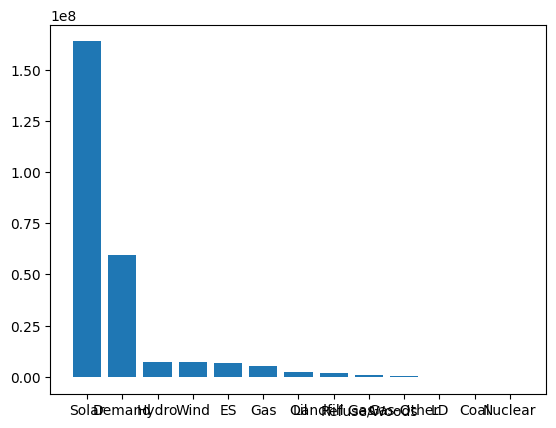

In [140]:
paymentsByFuel, csoByFuel = {}, {}
for i in range(len(genCos)):
    genco = genCos[i]
    if genco.fuelType in paymentsByFuel:
        paymentsByFuel[genco.fuelType] += payment[i].sum()
        csoByFuel[genco.fuelType] += genco.CapObl
    else:
        paymentsByFuel[genco.fuelType]  = payment[i].sum()
        csoByFuel[genco.fuelType] = genco.CapObl

index = np.argsort(list(paymentsByFuel.values()))
index = index[::-1]
val = np.array(list(paymentsByFuel.values()))[index] / 1000
plt.bar(np.array(list(paymentsByFuel.keys()))[index], val, label=  ' Payments')